# Fig. 6 - Properties of spontaneous and evoked events in the rate model with noise.

Here we have a noisy input mimicking synaptic current updates are injected to each rate-model population (see paper for more details). The noise is modelled as a Poisson-distributed spikes convoluted with synaptic kernel.

In [1]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neurolib.models.multimodel import MultiModel
from neurolib.utils.stimulus import StepInput, ZeroInput
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt, find_peaks, peak_widths

from hippocampus import HIPPOCAMPUS_NODE_DEFAULT_CONNECTIVITY, HippocampalCA3Node
from utils import AnchoredHScaleBar

plt.style.use("default_light")

## Helper functions and constants
- `simulate_hc_spontaneous`: integrates the model with noise for a given time (long simulations, ~ 10 minutes, to get the statistics of SWR events), no stimulation here
- `detect_peaks`: simple peak detector. Peaks are SWR events and these are detected on the low-pass filtered output from the B population
- `fit_func`: exponential function used for fitting the relationship of SWR amplitude and previous inter event interval

In [2]:
DT = 0.05
SAMPLING_DT = 0.1
HIGH_FILT_THRESH = 10.0  # Hz
PEAK_HEIGHT = 0.045  # kHz
PEAK_DIST = 100.0  # ms


def simulate_hc_spontaneous(duration=60, backend="numba"):
    hc = HippocampalCA3Node(aswr_mass_type="variable_depression")
    m = MultiModel.init_node(hc)
    m.model_instance.initial_state = np.array([0.0001, 0.003, 0.012, 0.649])
    m.params["backend"] = backend
    m.params["duration"] = duration * 1e3
    m.params["dt"] = DT
    m.params["sampling_dt"] = SAMPLING_DT
    m.run()
    return m.xr()


def detect_peaks(ts, time_vec):
    # low-pass filter
    nyq = 0.5 * (1e3 / SAMPLING_DT)
    high = HIGH_FILT_THRESH / nyq
    b_filt, a_filt = butter(2, high, btype="low", analog=False)
    lowpass_sig = filtfilt(b_filt, a_filt, ts)
    # detect peaks
    pks, _ = find_peaks(
        lowpass_sig,
        height=PEAK_HEIGHT,
        distance=int(PEAK_DIST / SAMPLING_DT),
    )
    # peak widths - FWHM
    widths = peak_widths(lowpass_sig, pks, rel_height=0.5)[0]
    # indices of start and end
    peaks_start = (pks - widths // 2).astype(int)
    peaks_end = (pks + widths // 2).astype(int)
    durations = time_vec[peaks_end] - time_vec[peaks_start]
    amplitudes = lowpass_sig[pks]
    # discard first start and last end and then subtract
    inter_event_interval = time_vec[peaks_start][1:] - time_vec[peaks_end][:-1]

    return pks, inter_event_interval, amplitudes


def fit_func(x, a, b, c):
    return a * (1.0 - np.exp(-b * x)) + c

## Compute and plot spontaneous

We run 10 minutes simulation and detect **spontaneous** SWR events. SWR events are detected on low-passed output of the B population (i.e. low-passed firing rate of PV$^{+}$ basket cells) and plot the excerpt of the timeseries and SWR statistics: the distribution of inter event intervals (IEI), and relationship between previous IEI and SWR amplitude and next IEI and SWR amplitude.

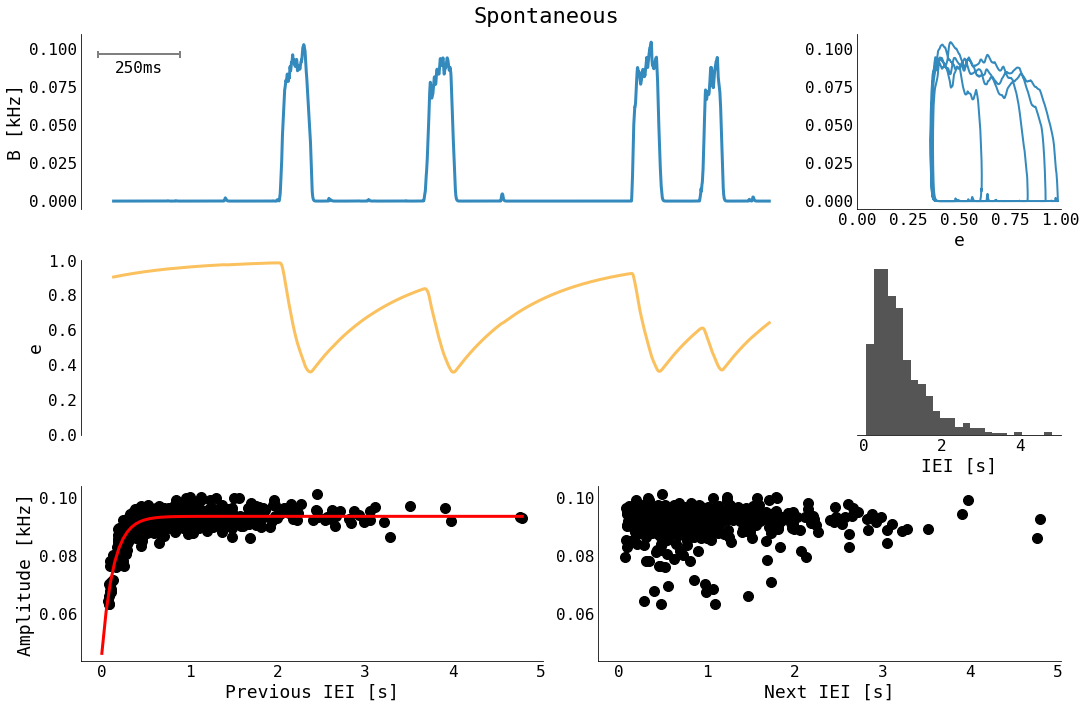

In [4]:
# simulate 10 minutes
res = simulate_hc_spontaneous(duration=600, backend="numba")

peaks, iei, amps = detect_peaks(
    res.sel({"output": "r_mean_INH"}).squeeze().values, res.time.values
)
# find 2 seconds with at least 3 peaks
rolling_sum_iei = np.cumsum(iei)
rolling_sum_iei[2:] = rolling_sum_iei[2:] - rolling_sum_iei[:-2]
rolling_sum_iei = rolling_sum_iei[1:]
at_least_3peaks = np.where(rolling_sum_iei < 1.8)[0][0]
mid_point = peaks[at_least_3peaks + 1] * SAMPLING_DT * 1e-3
res = res.sel({"time": slice(mid_point - 1.0, mid_point + 1.0)})

plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 4)
cols = ["C1", "C4"]
fields = ["r_mean_INH", "e_aSWR"]
ylabels = ["B [kHz]", "e"]

for i in range(2):
    ax = plt.subplot(gs[i, :3])
    ax.plot(res.time, res.sel({"output": fields[i]}).T, color=cols[i], linewidth=3)
    ax.set_xticks([])
    ax.set_ylabel(ylabels[i])
    sns.despine(ax=ax, bottom=True)
    if i == 0:
        bar = AnchoredHScaleBar(
            size=0.25,
            label="250ms",
            loc=2,
            linekw=dict(color="gray", linewidth=2.0),
            ax=ax,
        )
        ax.add_artist(bar)
    if i == 1:
        ax.set_ylim([0, 1])

# phase plane B-e
ax = plt.subplot(gs[0, -1])
ax.plot(
    res.sel({"output": "e_aSWR"}).T, res.sel({"output": "r_mean_INH"}).T, color=cols[0]
)
ax.set_xlim([0, 1])
ax.set_xlabel("e")
sns.despine(ax=ax)

# IEI
ax = plt.subplot(gs[1, -1])
ax.hist(iei, bins=25, fc="#555555")
sns.despine(ax=ax, left=True)
ax.set_yticks([])
ax.set_xlabel("IEI [s]")

# SWR amp vs. IEI
ax = plt.subplot(gs[2, :2])
ax.plot(iei, amps[1:], "o", color="k")
# fit
fit_params, _ = curve_fit(
    fit_func, iei, amps[1:], p0=(2, 2, 68), bounds=(0, [100, 100, 100])
)
fit_iei = np.linspace(0, iei.max(), 100)
ax.plot(fit_iei, fit_func(fit_iei, *fit_params), color="red", linewidth=3)
ax.set_xlabel("Previous IEI [s]")
ax.set_ylabel("Amplitude [kHz]")
sns.despine(ax=ax)

ax = plt.subplot(gs[2, 2:], sharey=ax, sharex=ax)
ax.plot(iei, amps[:-1], "o", color="k")
ax.set_xlabel("Next IEI [s]")
sns.despine(ax=ax)

plt.suptitle("Spontaneous")
plt.tight_layout()

plt.savefig("../figs/rate_spontaneous_SWR.pdf", transparent=True, bbox_inches="tight")

## Repeat spontaneous for `jitcdde` backend

/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:1491: UserWarning: Your input past does not begin at t=0 but at t=0.1. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")


Using default integration parameters.


  0%|          | 0/1200000 [00:00<?, ?it/s]/Users/nikola/.virtualenvs/paper_hc/lib/python3.7/site-packages/jitcdde/_jitcdde.py:791: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 1200000/1200000 [00:06<00:00

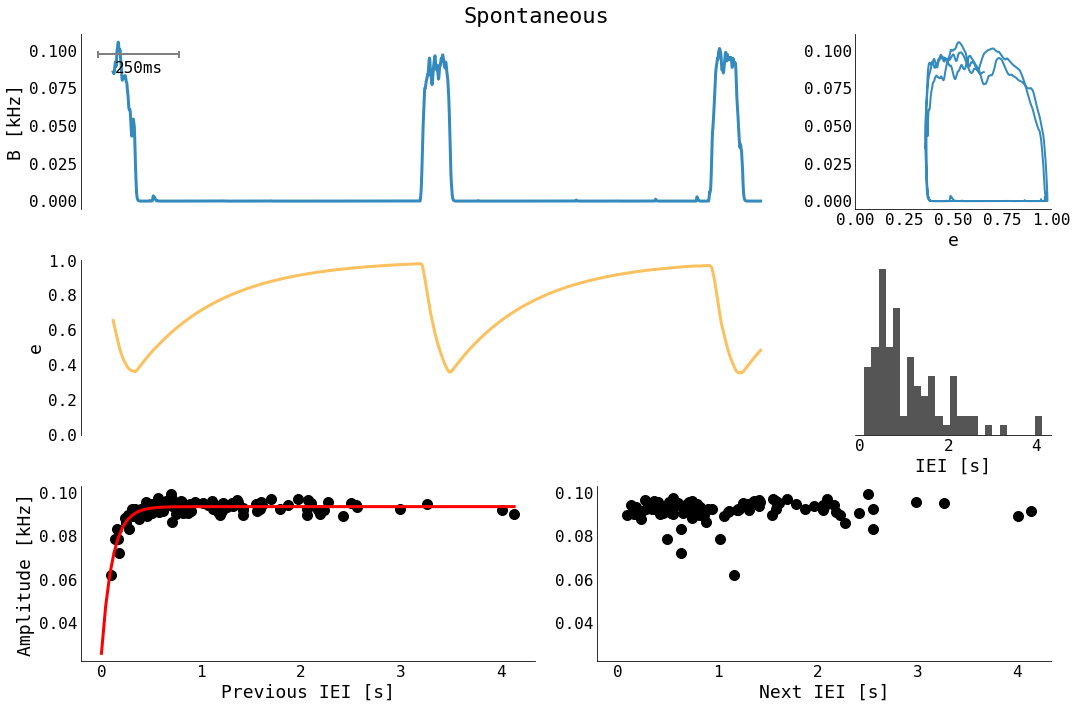

In [5]:
# simulate 2 minutes due to computational time
res = simulate_hc_spontaneous(duration=120, backend="jitcdde")

peaks, iei, amps = detect_peaks(
    res.sel({"output": "r_mean_INH"}).squeeze().values, res.time.values
)
# find 2 seconds with at least 3 peaks
rolling_sum_iei = np.cumsum(iei)
rolling_sum_iei[2:] = rolling_sum_iei[2:] - rolling_sum_iei[:-2]
rolling_sum_iei = rolling_sum_iei[1:]
at_least_3peaks = np.where(rolling_sum_iei < 1.8)[0][0]
mid_point = peaks[at_least_3peaks + 1] * SAMPLING_DT * 1e-3
res = res.sel({"time": slice(mid_point - 1.0, mid_point + 1.0)})

plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 4)
cols = ["C1", "C4"]
fields = ["r_mean_INH", "e_aSWR"]
ylabels = ["B [kHz]", "e"]

for i in range(2):
    ax = plt.subplot(gs[i, :3])
    ax.plot(res.time, res.sel({"output": fields[i]}).T, color=cols[i], linewidth=3)
    ax.set_xticks([])
    ax.set_ylabel(ylabels[i])
    sns.despine(ax=ax, bottom=True)
    if i == 0:
        bar = AnchoredHScaleBar(
            size=0.25,
            label="250ms",
            loc=2,
            linekw=dict(color="gray", linewidth=2.0),
            ax=ax,
        )
        ax.add_artist(bar)
    if i == 1:
        ax.set_ylim([0, 1])

# phase plane B-e
ax = plt.subplot(gs[0, -1])
ax.plot(
    res.sel({"output": "e_aSWR"}).T, res.sel({"output": "r_mean_INH"}).T, color=cols[0]
)
ax.set_xlim([0, 1])
ax.set_xlabel("e")
sns.despine(ax=ax)

# IEI
ax = plt.subplot(gs[1, -1])
ax.hist(iei, bins=25, fc="#555555")
sns.despine(ax=ax, left=True)
ax.set_yticks([])
ax.set_xlabel("IEI [s]")

# SWR amp vs. IEI
ax = plt.subplot(gs[2, :2])
ax.plot(iei, amps[1:], "o", color="k")
# fit
fit_params, _ = curve_fit(
    fit_func, iei, amps[1:], p0=(2, 2, 68), bounds=(0, [100, 100, 100])
)
fit_iei = np.linspace(0, iei.max(), 100)
ax.plot(fit_iei, fit_func(fit_iei, *fit_params), color="red", linewidth=3)
ax.set_xlabel("Previous IEI [s]")
ax.set_ylabel("Amplitude [kHz]")
sns.despine(ax=ax)

ax = plt.subplot(gs[2, 2:], sharey=ax, sharex=ax)
ax.plot(iei, amps[:-1], "o", color="k")
ax.set_xlabel("Next IEI [s]")
sns.despine(ax=ax)

plt.suptitle("Spontaneous")
plt.tight_layout()

## Profit: spontaneous

We got same figures. Naturally, since this is noisy simulation, the spontaneous SWRs would be at different timestamps, but the statistics of SWR are the same (accounting for shorter `jitcdde` simulation).

All good.